# Cat vs Dog

# Transfer Learning Using Pretrained ConvNets

In this tutorial you will learn how to classify cats vs dogs images by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale 
image-classification task. You either use the pretrained model as it is, or use transfer learning to customize this model 
to a given task.

The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will
effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without
having to start from scratch training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples.
You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose
the feature maps learned previously for our dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that are generically
useful for classifying pictures. However, the final, classification part of the pretrained model is specific to original 
classification task, and subsequently specific to the set of classes on which the model was trained.

Fine-Tuning: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier 
layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the 
base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

Examine and understand the data
Build an input pipeline, in this case using Keras ImageDataGenerator
Compose our model
Load in our pretrained base model (and pretrained weights)
Stack our classification layers on top
Train our model
Evaluate model

In [1]:
import keras
from keras.layers import Dense
from keras.models import Model
import os

Using TensorFlow backend.


In [2]:
print(os.getcwd())
os.chdir(r"C:\Users\user\Downloads\image_classifier")   # local directory which contains Dog-Cat Dataset

C:\Users\user


In [4]:
mobile=keras.applications.mobilenet.MobileNet()  # importing pretrained model 







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
mobile.summary()  

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [6]:
x=mobile.layers[-6].output # modifying the architecture from the last 5 layers and adding a layer according to our problem
p=Dense(2,activation='softmax')(x)

In [7]:
model=Model(inputs=mobile.input,outputs=p)  # new model according to our need

In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [9]:
# Just want to train last 5 layers
for layer in model.layers[:-5]:     # freezing all the layers except the last 5 ones 
    layer.trainable=False

In [10]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
train_path=os.path.join(os.getcwd(),'training_set')
test_path=os.path.join(os.getcwd(),'test_set')

In [12]:
print(train_path)
print(test_path)

C:\Users\user\Downloads\image_classifier\training_set
C:\Users\user\Downloads\image_classifier\test_set


In [13]:
from keras.applications.mobilenet import preprocess_input # to preprocess the data according to the Pretrained model

In [14]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path,target_size=(224,224),batch_size=50)
test_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path,target_size=(224,224),batch_size=50)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [16]:
history=model.fit_generator(train_datagen,epochs=2,validation_data=(test_datagen))

Epoch 1/2
161/161 [==============================] - 956s 6s/step - loss: 0.1112 - acc: 0.9644 - val_loss: 0.0476 - val_acc: 0.9857
Epoch 2/2
161/161 [==============================] - 897s 6s/step - loss: 0.0416 - acc: 0.9867 - val_loss: 0.5199 - val_acc: 0.9086


# Learning Curves

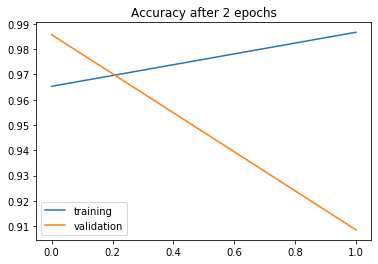

In [26]:
import matplotlib.pyplot as plt
plt.title("Accuracy after 2 epochs")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','validation'])

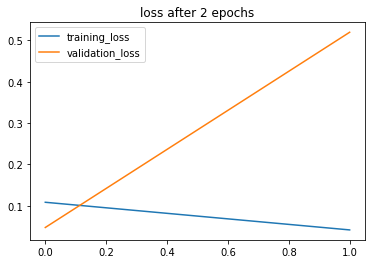

In [27]:
plt.title("loss after 2 epochs")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss','validation_loss'])

# Summary:
Using a pre-trained model for feature extraction: When working with a small dataset, it is common to take advantage of features 
learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and 
adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get 
updated during training. In this case, the convolutional base extracted all the features associated with each image and you 
just trained a classifier that determines the image class given that set of extracted features.